In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text as txt

## STEP 1: Load and Preprocess the Dataset

A Dutch NER dataset can be downloaded from [here](https://www.clips.uantwerpen.be/conll2002/ner/).

We use the `entities_from_conll2003` function to load and preprocess the data, as the dataset is in a standard **CoNLL** format. (Download the data from the link above to see what the format looks like.)

See the *ktrain* [sequence-tagging tutorial](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-06-sequence-tagging.ipynb) for more information on how to load data in different ways.

In [3]:
TDATA = 'data/dutch_ner/ned.train'
VDATA = 'data/dutch_ner/ned.testb'
(trn, val, preproc) = txt.entities_from_conll2003(TDATA, val_filepath=VDATA,  use_char=False)

detected encoding: ISO-8859-1 (if wrong, set manually)
Number of sentences:  15806
Number of words in the dataset:  27803
Tags: ['I-PER', 'B-MISC', 'O', 'B-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'I-MISC', 'B-ORG']
Number of Labels:  9
Longest sentence: 859 words


## STEP 2:  Build the Model

Next, we will build a Bidirectional LSTM model that employs the use of [BERT word embeddings](https://arxiv.org/abs/1810.04805).  By default, the `sequence_tagger` will use a pretrained multilingual model (i.e., `bert-base-multilingual-cased`).  However, since we are training a Dutch-language model, it is better to select the Dutch pretrained BERT model: `bert-base-dutch-cased`.  A full list of available pretrained models is [listed here](https://huggingface.co/transformers/pretrained_models.html).  *ktrain* currently supports any `bert=-*` model in addition to any `distilbert-*` or `albert-*` model.

In [4]:
WV_URL='https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.nl.300.vec.gz'
model = txt.sequence_tagger('bilstm-bert', preproc, 
                            bert_model='bert-base-dutch-cased', wv_path_or_url=WV_URL)

Embedding schemes employed (combined with concatenation):
	word embeddings initialized with fasttext word vectors (cc.nl.300.vec.gz)
	BERT embeddings with bert-base-dutch-cased
	character embeddings

pretrained word embeddings will be loaded from:
	https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.nl.300.vec.gz
loading pretrained word vectors...this may take a few moments...


In the cell above, notice that we suppied the `wv_path_or_url` argument. This directs *ktrain* to initialized word embeddings with one of the pretrained fasttext (word2vec) word vector sets from [Facebook's fastttext site](https://fasttext.cc/docs/en/crawl-vectors.html).   When supplied with a valid URL to a `.vec.gz`, the word vectors will be automatically downloaded, extracted, and loaded in STEP 2 (download location is `<home_directory>/ktrain_data`). To disable pretrained word embeddings, set `wv_path_or_url=None` and randomly initialized word embeddings will be employed. Use of pretrained embeddings will typically boost final accuracy. When used in combination with a model that uses an embedding scheme like BERT (e.g., `bilstm-bert`), the different word embeddings are stacked together using concatenation.

Finally, we will wrap our selected model and datasets in a `Learner` object to facilitate training.

In [5]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

## STEP 3:  Train the Model

We will train for 5 epochs and decay the learning rate using cosine annealing.  This is equivalent to one cycle with a length of 5 epochs. We will save the weights for each epoch in a checkpoint folder. Will train with a learning rate of `0.01`, previously identified using our [learning-rate finder](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-02-tuning-learning-rates.ipynb).

In [6]:
learner.fit(0.01, 1, cycle_len=5, checkpoint_folder='/tmp/saved_weights')

preparing train data ...done.
preparing valid data ...done.
Train for 124 steps, validate for 41 steps
Epoch 1/5
124/124 [==============================] - 83s 666ms/step - loss: 0.0699 - val_loss: 0.0212
Epoch 2/5
124/124 [==============================] - 73s 587ms/step - loss: 0.0167 - val_loss: 0.0135
Epoch 3/5
124/124 [==============================] - 73s 585ms/step - loss: 0.0083 - val_loss: 0.0131
Epoch 4/5
124/124 [==============================] - 73s 592ms/step - loss: 0.0053 - val_loss: 0.0123
Epoch 5/5
124/124 [==============================] - 73s 591ms/step - loss: 0.0040 - val_loss: 0.0123


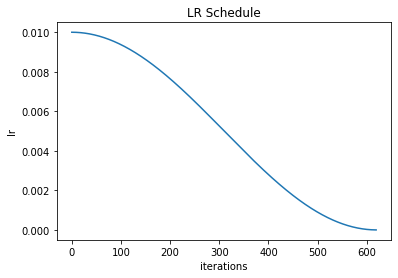

In [7]:
learner.plot('lr')

As shown below, our model achieves an F1-Sccore of 83.04. While this is lower than our NER results for other languages like [English, Chinese, and Russian](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/examples/text/shallownlp-examples.ipynb), it appears to be higher than the [Spacy Dutch NER model](https://spacy.io/models/nl).

In [8]:
learner.validate(class_names=preproc.get_classes())

   F1: 83.04
           precision    recall  f1-score   support

      PER       0.92      0.94      0.93      1097
      LOC       0.88      0.90      0.89       772
     MISC       0.74      0.76      0.75      1187
      ORG       0.72      0.84      0.77       882

micro avg       0.81      0.85      0.83      3938
macro avg       0.81      0.85      0.83      3938



0.8303891290920322

## STEP 4:  Make Predictions

In [9]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [10]:
dutch_text = """Marke Rutte is een Nederlandse politicus die momenteel premier van Nederland is."""
predictor.predict(dutch_text)

[('Marke', 'B-PER'),
 ('Rutte', 'I-PER'),
 ('is', 'O'),
 ('een', 'O'),
 ('Nederlandse', 'B-MISC'),
 ('politicus', 'O'),
 ('die', 'O'),
 ('momenteel', 'O'),
 ('premier', 'O'),
 ('van', 'O'),
 ('Nederland', 'B-LOC'),
 ('is', 'O'),
 ('.', 'O')]

In [11]:
predictor.save('/tmp/my_dutch_nermodel')

The `predictor` can be re-loaded from disk with with `load_predictor`:

In [13]:
predictor = ktrain.load_predictor('/tmp/my_dutch_nermodel')

In [15]:
predictor.predict(dutch_text)

[('Marke', 'B-PER'),
 ('Rutte', 'I-PER'),
 ('is', 'O'),
 ('een', 'O'),
 ('Nederlandse', 'B-MISC'),
 ('politicus', 'O'),
 ('die', 'O'),
 ('momenteel', 'O'),
 ('premier', 'O'),
 ('van', 'O'),
 ('Nederland', 'B-LOC'),
 ('is', 'O'),
 ('.', 'O')]